In [48]:
# This notebook implements some basic introductory tutorials from Lux.jl
using Lux, NeuralPDE, Zygote
using ModelingToolkit
using ModelingToolkit: Interval
using OrdinaryDiffEq

using ProgressMeter
using Gnuplot
gpexec("load '~/gpconfig.cfg'")
import Base.show # this is needed otherwise the next line just defines a new function in a new module
show(io::IO, ::MIME"text/html", gp::Gnuplot.GPSession) = Gnuplot._show(io, gp, "svg enhanced standalone mouse size 400,250")
Gnuplot.options.verbose = false;
dump(Gnuplot.options) # print out the options

# https://julialang.slack.com/archives/C690QRAA3/p1711534935292689
# What is the relationship between Optimization.jl and Optimisers.jl?
# Optimization.jl is an interface over a whole set of optimization packages. It's the level of DifferentialEquations.jl, NonlinearSolve.jl, LinearSolve.jl, interfacing to tons (>10?) optimization packages.
# Optimisers.jl is a specific library of optimizers. Optimisers.jl is a specific library of optimizers.
# Optimization.jl has a wrapper for using Optimisers.jl methods (OptimizationOptimisers.jl), and that's the most common way things are trained with SciML applications like Neural ODEs.
# Optim.jl (OptimizationOptimJL.jl) is another Julia package implementing various algorithms to perform univariate and multivariate optimization
using Optimization, OptimizationOptimJL, OptimizationOptimisers
using Random, Statistics

Gnuplot.Options
  dry: Bool false
  cmd: String "gnuplot"
  default: Symbol default
  term: String "qt 0 font \"Sans,9\""
  gpviewer: Bool false
  init: Array{String}((0,))
  verbose: Bool false
  preferred_format: Symbol auto


In [74]:
# Let's solve a basic ODE using the NNODE API and the default DiffEq API (i.e, define out of order ODE)
# u' = cos(2pit)

# Question: In this example and the same example below (but using the PINN API instead of NNODE), 
# there is no 'data' points -- and the loss function is only computed on the colocation points. 
# from the tutorial without using MTK 
linear(u, p, t) = cos(t * 2 * pi)
tspan = (0.0, 1.0)
u0 = 0.0
prob = ODEProblem(linear, u0, tspan)

rng = Random.default_rng()
Random.seed!(rng, 0)
chain = Chain(Dense(1, 5, σ), Dense(5, 1))
ps, st = Lux.setup(rng, chain) |> Lux.f64

opt = OptimizationOptimisers.Adam(0.1)
alg = NNODE(chain, opt, init_params = ps)

sol = solve(prob, alg, verbose = false, maxiters = 500, saveat = 0.01)
sol_d = solve(prob, Tsit5(), reltol = 1e-8, abstol = 1e-8) # uses the numerical solver algorithm 


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 34-element Vector{Float64}:
 0.0
 9.999999999999999e-5
 0.0010999999999999998
 0.007608665069044807
 0.019035417073574423
 0.03259264087798058
 0.04936038347757517
 0.0685620774777402
 0.09044150520460895
 0.11463074533675897
 ⋮
 0.6867629392648357
 0.7257143883144905
 0.7683499450090805
 0.8280106011041108
 0.8657269795730727
 0.909406274348581
 0.9475532719360347
 0.9863021219300219
 1.0
u: 34-element Vector{Float64}:
  0.0
  9.999999342026382e-5
  0.0010999912423919444
  0.00760576716328024
  0.018990066263944866
  0.03236531104043904
  0.04857287516511574
  0.06646105973864518
  0.08565192962867807
  0.10497378725775501
  ⋮
 -0.14675635735411524
 -0.15730565234081026
 -0.15809827562005463
 -0.14041602028884242
 -0.11890188132040072
 -0.08578018844688727
 -0.05150265640458562
 -0.013680974222047492
 -8.542363836123353e-10

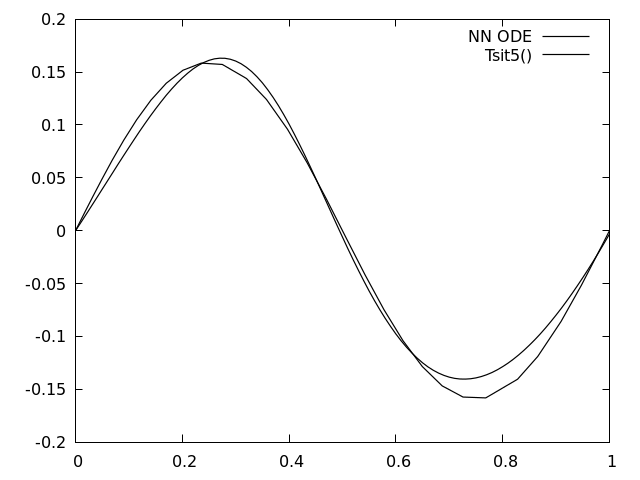

34-element Vector{Float64}:
  0.0
  9.999999342026382e-5
  0.0010999912423919444
  0.00760576716328024
  0.018990066263944866
  0.03236531104043904
  0.04857287516511574
  0.06646105973864518
  0.08565192962867807
  0.10497378725775501
  ⋮
 -0.14675635735411524
 -0.15730565234081026
 -0.15809827562005463
 -0.14041602028884242
 -0.11890188132040072
 -0.08578018844688727
 -0.05150265640458562
 -0.013680974222047492
 -8.542363836123353e-10

In [75]:
@gp "reset" 
@gp :- sol.t sol.u "with lines title 'NN ODE' lw 1.2 lc 'black'"
@gp :- sol_d.t sol_d.u "with lines title 'Tsit5()' lw 1.2 lc 'black'"
display(@gp)
sol_d.u

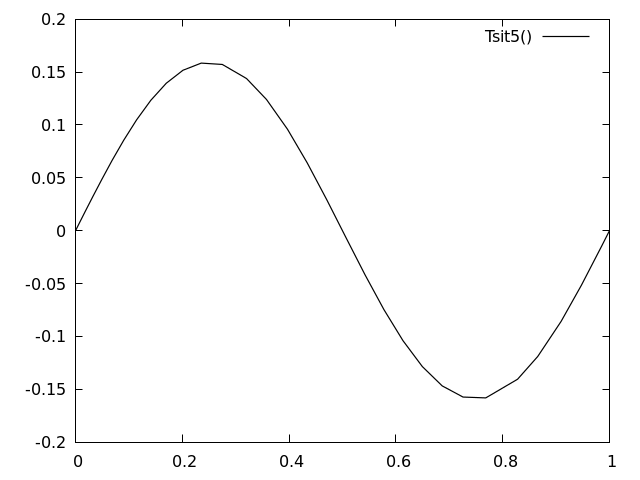

In [80]:
# Can we use the modelling toolkit to solve the simple ODE? 
# for learning purposes -- without using NN for now
@parameters t 
@variables m(..)
Dt = Differential(t)
eqs = Dt(m(t)) ~ cos(t * 2 * pi)
@mtkbuild c = ODESystem(eqs, t)
prob = ODEProblem(c, 0.0, (0.0, 1.0))
sol_d = solve(prob, Tsit5(), reltol = 1e-8, abstol = 1e-8) # uses the numerical solver algorithm 

@gp "reset" 
@gp :- sol_d.t sol_d[1, :] "with lines title 'Tsit5()' lw 1.2 lc 'black'"

In [2]:
# Now can we do this using the PINNs interface? 
# According to Chris, ODEs should only use the NNODE API -- not the PINNs API, but we can try
# we can follow the instructions here https://docs.sciml.ai/NeuralPDE/stable/tutorials/param_estim/
@parameters t 
@variables m(..)
Dt = Differential(t)
eqs = [Dt(m(t)) ~ cos(t * 2 * pi)]
bcs = [m(0) ~ 0.0]
domains = [t ∈ Interval(0.0, 1.0)]
dt = 0.01
input_ = length(domains) # just one input -- t 
n = 5 # number of neurons in the hidden layer
chain1 = Lux.Chain(Dense(input_, n, Lux.σ),  Dense(n, 1, Lux.identity))
discretization = NeuralPDE.PhysicsInformedNN([chain1], NeuralPDE.GridTraining(dt), param_estim = false)
@named pde_system = PDESystem(eqs, bcs, domains, [t], [m(t)])
prob = NeuralPDE.discretize(pde_system, discretization) 
res = Optimization.solve(prob, OptimizationOptimisers.Adam(0.1); maxiters = 1000)

LoadError: LoadError: UndefVarError: `@parameters` not defined
in expression starting at /home/affans/pinns_julia_1/lorenzs.ipynb:5

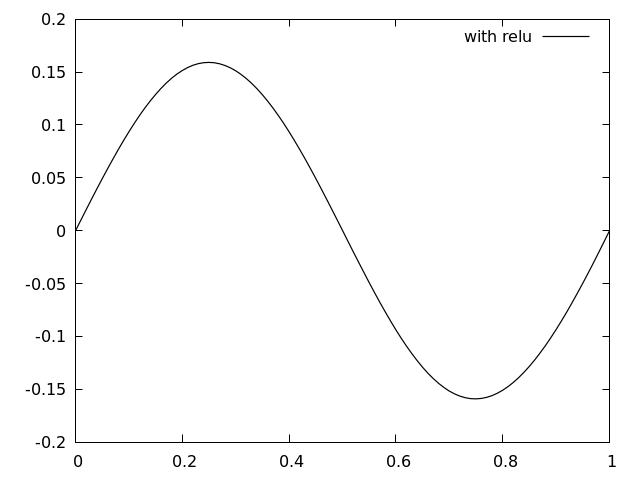

In [198]:
minimizers = res.u.depvar[:m] # returns the weights and bias of the neural network (i.e., chain1 will have same number of parameters)
ts = [infimum(d.domain):dt:supremum(d.domain) for d in domains][1]

#discretization.phi
test_sol = discretization.phi[1] # solution function, index 1 since there is only one function m(x)
sol_pinn = [test_sol(tt, minimizers)[1] for tt in ts]
#test_sol(276, minimizers)
@gp "reset" 
@gp :- ts sol_pinn "with lines title 'with relu' lw 1.2 lc 'black'"

# Parameter estimation. 
---- 

Can we estimate parameters of a system? Consider the Lorenz system: 
$$
\begin{aligned} 
    x' &= \sigma (y - x) \\
    y' &= x (\rho - z) - y \\
    z' &= xy - \beta z
\end{aligned}
$$
with parameter values $\sigma = 10.0, \rho = 28.0, \beta = \frac{8}{3}$